# OWIDplusLIVE

Das folgende Jupyter-Notebook dokumentiert die API von OWIDplusLIVE (www.owid.de/plus/live-2021) in der Version 3.0 (ab 2025)


## Hinweis

Dieses Notebook läuft direkt in ihrem Web-Browser. Alle Python-Pakete sind als installiert. Wenn Sie den Code auf ihrem Rechner ausführen, kann es sein, dass Sie die Pakete selbst installieren müssen. Folgende Pakete sind erforderlich (requierements.txt):<br/>
<br/>
numpy<br/>
matplotlib<br/>
plotly<br/>
plotly[express]<br/>
pandas<br/>
dayplot<br/>
pydantic<br/>
requests<br/>
nbformat<br/>
<br/>
Sollten Sie Pakete frisch installiert haben, denken Sie bitte daran, dass Sie den Python-Kernel des Jupyter Notebooks einmal neu starten müssen, damit die installierten Pakete verfügbar sind.


## Dependencies

Folgende Dependencies müssen einmalig nach dem Starten des Notebooks importiert werden. Bitte installieren Sie ggf. erforderliche Dependencies selbst.


In [ ]:
from enum import IntEnum
from pydantic import BaseModel
import matplotlib.pyplot as plt
import requests
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import dayplot as dp
import json

## API-Funktion und Hilfsfunktion

Dieser Code reproduziert die vollständige Funktionalität der Webanwendung OWIDplusLIVE innerhalb der lokalen Arbeitsumgebung.
Der nachfolgende Codeteil ist umfangreich und sollte einmalig vollständig ausgeführt werden. Die Ausführung benötigt lediglich wenige Sekunden.
Im Anschluss stehen sämtliche Funktionen zur Verfügung (siehe Beispiele im Abschnitt Playground unten).
Alle Funktionen sind umfassend dokumentiert, sodass über den Code-Editor jederzeit ein direkter Zugriff auf weiterführende Informationen und Parameterbeschreibungen möglich ist.


In [ ]:
# Basis URL der OWIDplusLIVE-API und Layer-Definitionen.
baseUrl = "https://www.owid.de/plus/live-2021/api/v3"

# Layer Mapping
layer = {"Wortform": 0, "Lemma": 1, "POS": 2}


def __req(endpoint: str) -> dict:
    """
    Führt eine GET-Anfrage an den angegebenen API-Endpunkt durch und gibt die JSON-Antwort zurück.
    Hinweis: Diese Funktion ist privat und sollte nicht direkt aufgerufen werden.

    Args:
        endpoint (str): Der API-Endpunkt (z. B. "/years", "/norm").

    Returns:
        dict: Die JSON-Antwort der API.
    """
    response = requests.get(f"{baseUrl}{endpoint}")
    response.raise_for_status()
    return json.loads(response.content.decode('utf-8-sig'))

# Lade verfügbare Jahre.
years = __req("/years")
years.sort(reverse=True)

# Lade Normdaten für N-Gramme (1, 2, 3).
response = __req("/norm")
normGram = {i + 1: dict(sorted(response[i].items())) for i in range(3)}

# Vordefinierte Granulationsfunktionen
predefinedGranulationFuncs = {
    "date": lambda d: d,
    "week": lambda d: d - pd.to_timedelta(d.dt.weekday, unit='d'),
    "month": lambda d: d - pd.to_timedelta(d.dt.day - 1, unit='d'),
    "quarter": lambda d: d - pd.to_timedelta((d.dt.day - 1) + (d.dt.month - 1) % 3 * 30, unit='d'),
    "year": lambda d: d - pd.to_timedelta(d.dt.dayofyear - 1, unit='d'),
}

class LayerName(IntEnum):
    Wortform = 0
    Lemma = 1
    POS = 2

class SearchItem(BaseModel):
    """
    Repräsentiert ein Suchobjekt für die OWIDplusLIVE-API.

    Attribute:
        Position (int): Die Position des Tokens im N-Gramm (0-basiert).
        Layer (int): Die Ebene (z. B. Wortform, Lemma, POS).
        Token (str): Das zu suchende Token.
    """
    Position: int = 0
    Layer: int = 0
    Token: str = ""
    
    def __init__(self, Position=0, LayerName=LayerName.Wortform, Token=""):
        """
        Initialisiert ein SearchItem-Objekt.

        Args:
            Position (int): Die Position des Tokens im N-Gramm.
            LayerName (str): Der Name der Ebene (z. B. "Wortform", "Lemma" oder "POS").
            Token (str): Das zu suchende Token.
        """
        super().__init__(Position=Position, Layer=LayerName, Token=Token)

def __getFocusYear(year: int) -> list[int]:
    """
    Hilfsfunktion, um die Reihenfolge der Jahre zu bestimmen.

    Args:
        year (int): Das gewünschte Fokusjahr.

    Returns:
        list: Die Liste der Jahre in der Reihenfolge [Fokusjahr, alle anderen Jahre].
    """
    return [year] + [y for y in years if y != year]

def __normalizeData(n: int, df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalisiert (in pro Mio. Token) die Suchergebnisse basierend auf den Normdaten.
    Hinweis: Diese Funktion ist privat und sollte nicht direkt aufgerufen werden.

    Args:
        n (int): Die Anzahl der Tokens (N-Gramm).
        data (DataFrame): Die Suchergebnisse.

    Returns:
        DataFrame: Die Suchergebnisse ergänzt um eine Spalte mit den normalisierten Werten.
    """
    if "Frequenz (ppm)" in df.columns:
        df.drop(columns=["Frequenz (ppm)"], inplace=True)
    df["Datum"] = df["Datum"].astype(str)
    df["Norm"] = df["Datum"].map(normGram[n])
    df["Frequenz (ppm)"] = df.apply(
        lambda row: (row["Frequenz"] / row["Norm"] * 1_000_000) if row["Norm"] > 0 else 0,
        axis=1,
    )
    
    df = df.drop(columns=["Norm"])
    df["Datum"] = pd.to_datetime(df["Datum"], format="%Y-%m-%d", errors='coerce')
    
    return df.sort_values(by=["Datum"]).reset_index(drop=True)

def __search(n: int, year: int, items: list[SearchItem]) -> pd.DataFrame:
    """
    Führt die eigentliche API-Abfrage durch. Diese Funktion ist privat und sollte
    nicht direkt aufgerufen werden. Verwenden Sie stattdessen die `searchN1`, 
    `searchN2`, `searchN3` oder `searchAdvanced`-Funktionen.

    Args:
        n (int): Die Anzahl der Tokens (N-Gramm).
        year (int): Das Fokusjahr.
        items (list[SearchItem]): Die Liste der Suchobjekte.

    Returns:
        DataFrame: Die Suchergebnisse.
    """
    frames = []
    for y in __getFocusYear(year):
        payload = {
            "N": n,
            "Year": y,
            "Items": [item.model_dump(exclude={"LayerName"}) for item in items],
        }
        response = requests.post(f"{baseUrl}/search", json=payload)
        response.raise_for_status()
        tmp = json.loads(response.content.decode('utf-8-sig'))

        for ngram, value in tmp.items():
            for date, freq in value.items():
                frames.append({"N-Gramm": ngram, "Datum": date, "Frequenz": freq})

    if not frames:
        return pd.DataFrame(columns=["N-Gramm", "Datum", "Frequenz"])

    df = pd.DataFrame(frames)    
    df["Frequenz"] = df["Frequenz"].astype(int)

    return __normalizeData(n, df)

def searchSimple(year: int, layer1: LayerName, token1: str, layer2: LayerName = LayerName.Wortform, token2: str = None, layer3: LayerName = LayerName.Wortform, token3: str = None) -> pd.DataFrame:
    """
    Führt eine N-Gramm-Suche mit N=1, 2 oder 3 Tokens durch.

    Args:
        year (int): Das Fokusjahr.
        layer1 (LayerName): Die Ebene des ersten Tokens (z. B. "Wortform", "Lemma" oder "POS").
        token1 (str): Das erste zu suchende Token.
        layer2 (LayerName): Die Ebene des zweiten Tokens (z. B. "Wortform", "Lemma" oder "POS").
        token2 (str): Das zweite zu suchende Token.
        layer3 (LayerName): Die Ebene des dritten Tokens (z. B. "Wortform", "Lemma" oder "POS").
        token3 (str): Das dritte zu suchende Token.

    Returns:
        pd.DataFrame: Die Suchergebnisse.
    """
    if token2 is None:
        return __search(1, year, [SearchItem(Position=0, LayerName=layer1, Token=token1)])
    if token3 is None:
        return __search(2, year, [SearchItem(Position=0, LayerName=layer1, Token=token1),
                                  SearchItem(Position=1, LayerName=layer2, Token=token2)])    
    return __search(3, year, [SearchItem(Position=0, LayerName=layer1, Token=token1),
                              SearchItem(Position=1, LayerName=layer2, Token=token2),
                              SearchItem(Position=2, LayerName=layer3, Token=token3)])

def searchAdvanced(year: int, n: int, items: list) -> pd.DataFrame:
    """
    Führt eine erweiterte N-Gramm-Suche mit beliebig vielen Layern durch.

    Args:
        year (int): Das Fokusjahr.
        n (int): Die Anzahl der Tokens (N-Gramm) - N=1 bis N=3 möglich.
        items (list[SearchItem]): Die Liste der Suchobjekte.
        normalize (bool): Gibt an, ob die Ergebnisse normalisiert werden sollen.

    Returns:
        pd.DataFrame: Die Suchergebnisse.
    """
    return __search(n, year, items)

def applyGranulation(n: int, df: pd.DataFrame, granulationFunc) -> pd.DataFrame:
    """
    Wendet die angegebene Granulationsfunktion auf die Daten an.
    Args:
        n (int): Die Anzahl der Tokens (N-Gramm).
        df (pd.DataFrame): Die Suchergebnisse.
        granulationFunc (function): Die Granulationsfunktion (z. B. granulationFunc_by_week). 
        Die Variable predefinedGranulationFuncs enthält vordefinierte Funktionen ("date", "week", "month", "quarter", "year").
        
    Returns:
        pd.DataFrame: Die granulierteren Suchergebnisse.
    """
    df["Datum"] = granulationFunc(df["Datum"])  # Granulationsfunktion anwenden
    df = (
        df.groupby(["N-Gramm", "Datum"], as_index=False)
        .agg({"Frequenz": "sum", "Frequenz (ppm)": "sum"})
    )
    return df.sort_values(by=["Datum"]).reset_index(drop=True)

def applyMovingAvarage(df: pd.DataFrame, avarageSize: int) -> pd.DataFrame:
    """
    Wendet einen gleitenden Durchschnitt auf die Daten an.
    Args:
        data (pd.DataFrame): Die Suchergebnisse.
        avarageSize (int): Die Größe des gleitenden Durchschnittsfensters.
    Returns:
        pd.DataFrame: Die geglätteten Suchergebnisse.
    """
    if avarageSize < 2:
        return df

    df = df.sort_values(by=["Datum"]).reset_index(drop=True)
    df["Frequenz"] = (
        df.groupby("N-Gramm")["Frequenz"]
        .transform(lambda x: x.rolling(window=avarageSize, min_periods=1).mean())
    )
    df["Frequenz (ppm)"] = (
        df.groupby("N-Gramm")["Frequenz (ppm)"]
        .transform(lambda x: x.rolling(window=avarageSize, min_periods=1).mean())
    )
    return df

def mergeAllResuls(n: int, df: pd.DataFrame, newLabel="All") -> pd.DataFrame:
    """
    Führt die Suchergebnisse aller N-Gramme zusammen.
    Wichtig, führen Sie diese Funktion immer vor der Granulation oder dem gleitenden Durchschnitt aus.
    
    Args:
        n (int): Die Anzahl der Tokens (N-Gramm).
        df (pd.DataFrame): Die Suchergebnisse.
        newLabel (str): Das Label für die zusammengeführten Ergebnisse.
    Returns:
        pd.DataFrame: Die zusammengeführten Suchergebnisse.
    """
    df = (
        df.groupby("Datum", as_index=False)["Frequenz"]
        .sum()
        .assign(**{"N-Gramm": newLabel})
    )    
    return __normalizeData(1, df)

def createSankeyData(n: int, df: pd.DataFrame) -> go.Sankey:
    """
    Erstellt die Datenstruktur für einen Sankey-Plot aus den Suchergebnissen.
    Args:
        n (int): Die Anzahl der Tokens (N-Gramm), z. B. 2 oder 3.
        data (pd.DataFrame): Die Suchergebnisse.
    Returns:
        go.Sankey: Die Datenstruktur für den Sankey-Plot.
    """
    if n < 2 or n > 3:
        raise ValueError("n must be 2 or 3 for Sankey diagram.")
    
    label_map = {}
    link_map = {}

    for _, row in df.iterrows():
        parts = row["N-Gramm"].split(" ")
        if len(parts) != n:
            continue

        for part in parts:
            if part not in label_map:
                label_map[part] = len(label_map)

        for i in range(len(parts) - 1):
            source = label_map[parts[i]]
            target = label_map[parts[i + 1]]
            link_key = (source, target)
            link_map[link_key] = link_map.get(link_key, 0) + row["Frequenz (ppm)"]

    sources, targets, values = zip(*[(src, tgt, val) for (src, tgt), val in link_map.items()])

    return go.Sankey(
        node=dict(label=list(label_map.keys())),
        link=dict(source=sources, target=targets, value=values)
    )

def __lookup(year: int, layer: LayerName, wordformSet: set) -> dict:
    """
    Führt eine Lookup-Abfrage für die angegebenen Tokens in der angegebenen Ebene durch.
    Diese Funktion ist privat und sollte nicht direkt aufgerufen werden.

    Args:
        year (int): Das Fokusjahr.
        layer (LayerName): Die Ebene (Lemma oder POS).
        wordformSet (set[str]): Die Liste der zu suchenden Tokens.

    Returns:
        dict: Die Lookup-Ergebnisse.
    """
    wordformSet = list(wordformSet)
    payload = {
        "Layer": layer,
        "Year": year,
        "Query": " ".join(wordformSet),
    }
    response = requests.post(f"{baseUrl}/lookup", json=payload)
    response.raise_for_status()
    tmp = json.loads(response.content.decode('utf-8-sig')).get("Lookup", "").split(" ")
    if len(tmp) != len(wordformSet):
        print(len(tmp), len(wordformSet))
        raise ValueError("Lookup-Ergebnisse stimmen nicht mit der Anzahl der Suchbegriffe überein.")
        
    res = {}
    for i in range(len(wordformSet)):
        res[wordformSet[i]] = tmp[i]
    return res

def lookupSingle(year: int, layer: LayerName, ngram: str) -> dict:
    """
    Führt eine Lookup-Abfrage für ein einzelnes N-Gramm im angegebenen Layer durch.

    Args:
        year (int): Das Fokusjahr.
        layer (LayerName): Der Layer (Lemma oder POS).
        ngram (str): Das aufzulösende N-Gramm.

    Returns:
        dict: Die Lookup-Ergebnisse.
    """
    return __lookup(year, layer, {ngram})

def lookupDataFrame(year: int, layer: LayerName, data: pd.DataFrame) -> pd.DataFrame:
    """
    Ergänzt den pd.DataFrame um die aufgelösten Werte des Layers.

    Args:
        year (int): Das Fokusjahr.
        layer (LayerName): Der Layer (Lemma oder POS).
        data (pd.DataFrame): Der DataFrame mit den N-Grammen.

    Returns:
        pd.DataFrame: Die Lookup-Ergebnisse als DataFrame.
    """
    wordformSet = set()
    for ngram in data["N-Gramm"]:
        parts = ngram.split(" ")
        for part in parts:
            wordformSet.add(part)
    lookupRes = __lookup(year, layer, wordformSet)
    
    data[f"{layer.name}"] = data["N-Gramm"].apply(
        lambda ngram: " ".join([lookupRes.get(part, part) for part in ngram.split(" ")])
    )
    return data

## Playground

Hier finden Sie Beispiele zur Abfrage der API


### N=1


#### N=1 - Wortfrom = 'deutschland' mit Fokus auf 2020

Suche zuerst in 2020 nach der Wortform "deutschland" - gebe das Ergebnis ganz normal über die Konsole aus. Ausgegeben werden die ersten 10 Tage für die Übereinstimmung (hier nur 'deutschland' - siehe auch nächstes Beispiel) sowie die absolute Frequenz pro Tag.


In [4]:
data = searchSimple(2020, LayerName.Wortform, "deutschland")
print(data.head(10))

       N-Gramm      Datum  Frequenz  Frequenz (ppm)
0  deutschland 2020-01-01        56     1008.536541
1  deutschland 2020-01-02        42     1011.171032
2  deutschland 2020-01-03        74      953.436236
3  deutschland 2020-01-04        72     1461.305839
4  deutschland 2020-01-05        64     1142.775516
5  deutschland 2020-01-06        60      811.644392
6  deutschland 2020-01-07       113     1344.869857
7  deutschland 2020-01-08        90     1079.991360
8  deutschland 2020-01-09        90     1088.244541
9  deutschland 2020-01-10       107     1244.880864


#### N=1 - Lemma = 'sagen' mit Fokus 2024

Suche zuerst in 2024 nach dem Lemma 'sagen' - gebe alle Wortformen aus. Die Keys entsprechen den passenden Wortformen.


In [5]:
data = searchSimple(2024, LayerName.Lemma, "sagen")
print(data["N-Gramm"].unique())

['sagten' 'sagst' 'gesagt' 'sagt' 'sagen' 'sage' "sag's" 'sag' 'saget'
 "sagt's" 'sagte']


#### N=1 - Wortform = '\*sagte' mit Fokus 2023

Suche zuerst in 2023 nach allen Wortformen, die auf "sagte" enden. Nehme die TOP5 häufigsten N-Gramme und erzeuge eine Verlaufsgrafik.


In [6]:
# Suche
data = searchSimple(2023, LayerName.Wortform, "*sagte")

# Filtere DataFrame nach top 10 N-Gramme
top = data.groupby("N-Gramm")["Frequenz"].sum().nlargest(5).index
data = data[data["N-Gramm"].isin(top)]

# Plot mit Seaborn
fig = px.line(data, x="Datum", y="Frequenz", color="N-Gramm", markers=True, title="Vergleich der Verlaufskurven mit Plotly")
fig.update_layout(
  xaxis_title="Datum",
  yaxis_title="Frequenz / Wert",
  yaxis_type="log",
  template="plotly_white"
)
fig.show()

#### N=1 - Wortform = '\*sagte' mit Fokus 2023 + Granulierung (in Wochen) + Glättung (4)

Suche zuerst in 2023 nach allen Wortformen, die auf "sagte" enden. Nehme die TOP5 häufigsten N-Gramme und erzeuge eine Verlaufsgrafik. Die Daten werden nach Wochen granuliert und ein gleitender Durschnitt von vier Wochen wird berechnet.


In [7]:
# Suche
data = searchSimple(2023, LayerName.Wortform, "*sagte")

# Granuliere nach Wochen
data = applyGranulation(1, data, predefinedGranulationFuncs["week"])
# Glätte mit gleitendem Durchschnitt (4 Wochen)
data = applyMovingAvarage(data, 4)

# Filtere DataFrame nach top 10 N-Gramme
top = data.groupby("N-Gramm")["Frequenz"].sum().nlargest(5).index
data = data[data["N-Gramm"].isin(top)]

# Plot mit Seaborn
fig = px.line(data, x="Datum", y="Frequenz", color="N-Gramm", markers=True, title="Vergleich der Verlaufskurven mit Plotly")
fig.update_layout(
  xaxis_title="Datum",
  yaxis_title="Frequenz / Wert",
  yaxis_type="log",
  template="plotly_white"
)
fig.show()


### N=2


#### N=2 - Wortform="angela merkel" mit Fokus 2020

Suche zuerst in 2020 nach "angela merkel" (N=2), granuliere nach Monaten und wenden einen gleitenden Durchschnitt von 4 Monaten an. Erstelle dann einen Plot.


In [8]:
# Suche
data = searchSimple(2020, LayerName.Wortform, "angela", LayerName.Wortform, "merkel")

# Wenn mehrere Schreibvarianten, fasse die Ergebnisse zusammen
data = mergeAllResuls(2, data, newLabel="angela merkel")

# Granuliere nach Monaten
data = applyGranulation(2, data, predefinedGranulationFuncs["month"])

# Berechne gleitenden Durchschnitt (4 Monate)
data = applyMovingAvarage(data, 4)

# Plot mit Seaborn
fig = px.line(data, x="Datum", y="Frequenz", color="N-Gramm", markers=True, title="Verlaufskurve für 'angela merkel'")
fig.update_layout(
  xaxis_title="Datum",
  yaxis_title="Frequenz / Wert",
  yaxis_type="log",
  template="plotly_white"
)
fig.show()

#### N=2 - 1. Lemma = "sprechen" / 2. POS = "APPR" - ein Sankey-Plot

Erstelle für "sprechen APPR" einen Sankey-Plot.


In [9]:
# Suche
data = searchSimple(2024, LayerName.Lemma, "sprechen", LayerName.POS, "APPR")

# Erstelle Sankey-Daten
sankeyData = createSankeyData(2, data)

# Erstelle Sankey-Plot
fig = go.Figure(sankeyData)
fig.update_layout(title_text="Sankey-Plot für 'sprechen APPR'", font_size=10)
fig.update_layout(width=600, height=1000)
fig.show()

### N =3


#### N=3 - 1. POS = "APPR" / 2. Lemma = "menschlich" / 3. POS = "NN"

Sucht nach dem Tri-Gram "APPR menschlich NN" - z. B. "aus menschlicher sicht" summiert die Ergebnisse und erstellt eine Kalender-Heatmap.


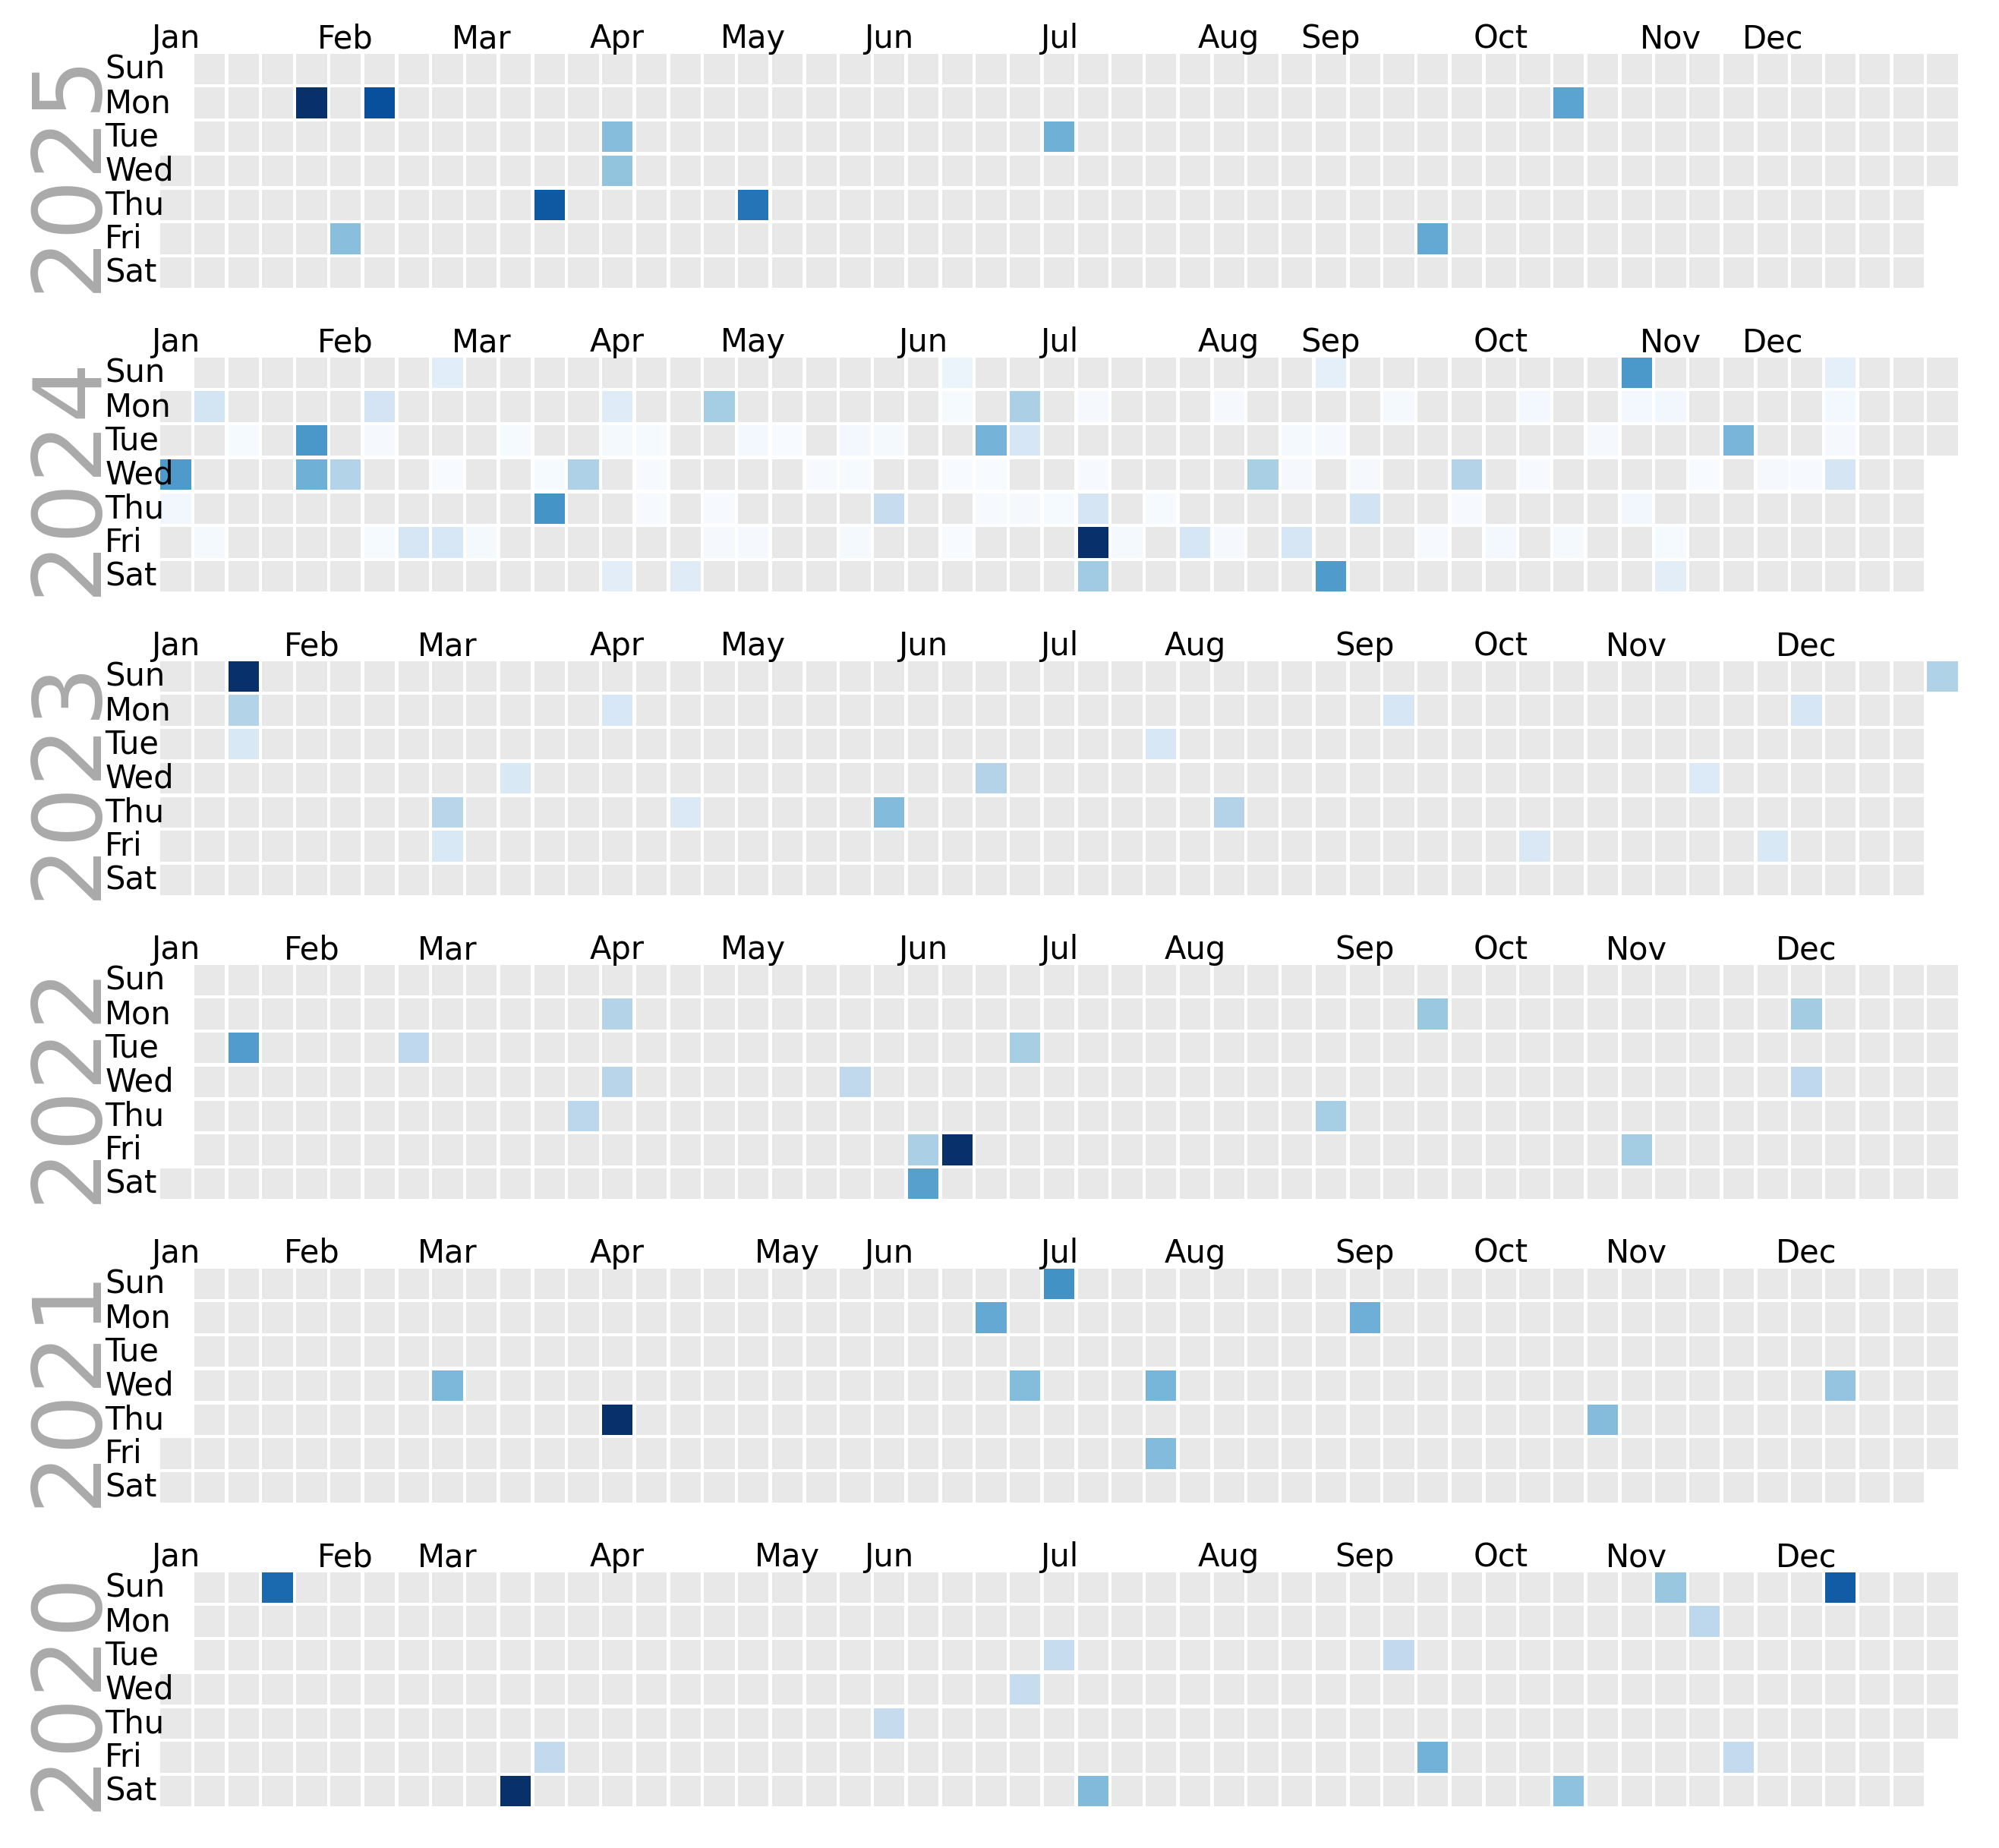

In [14]:
# Suche
data = searchSimple(2024, LayerName.POS, "APPR", LayerName.Lemma, "menschlich", LayerName.POS, "NN")

# Aggregiere alle Schreibvarianten
data = mergeAllResuls(3, data, newLabel="merkel KON NE")

# Einstellung für Label (Jahr)
text_args = dict(x=-4, y=3.5, size=30, rotation=90, color="#aaa", va="center")

fig, axes = plt.subplots(nrows=len(years), figsize=(10, 8), dpi=300, constrained_layout=True)

for ax, y in zip(axes, years):
    dp.calendar(
        dates=data[data["Datum"].dt.year == y]["Datum"],
        values=data[data["Datum"].dt.year == y]["Frequenz (ppm)"],
        ax=ax,
        cmap="Blues",
        start_date=f"{y}-01-01",
        end_date=f"{y}-12-31",
    )
    ax.text(**text_args, s=str(y))

plt.show()

#### N=3 - Export-Beispiel (1. POS = "APPR" / 2. Lemma = "menschlich" / 3. POS = "NN")

Folgendes Beispiel zeigt, wie Sie Daten ganz einfach speichern können. Da die Daten als pandas.DataFrame vorliegen, können sie diese in verschiedene Formate exportieren.


In [ ]:
# Suche
data = searchSimple(2024, LayerName.POS, "APPR", LayerName.Lemma, "menschlich", LayerName.POS, "NN")

data.to_csv("output.csv", index=False)
data.to_csv("output.tsv", index=False, sep='\t')
# ... usw.

#### N=3 - Lookup-Beispiel (1. POS = "APPR" / 2. Lemma = "menschlich" / 3. POS = "NN")

Die neue API fragt die Lemma/POS-Informationen getrennt ab. Dieses Beispiel zeigt, wie sie die Daten erhalten.


In [12]:
# Suche
data = searchSimple(2024, LayerName.POS, "APPR", LayerName.Lemma, "menschlich", LayerName.POS, "NN")

# Lookup POS
data = lookupDataFrame(2024, LayerName.POS, data)

# Lookup Lemma
data = lookupDataFrame(2024, LayerName.Lemma, data)

print(data.head(10))

                         N-Gramm      Datum  Frequenz  Frequenz (ppm)  \
0      über menschliche abgründe 2020-01-01         0             0.0   
1        auf menschlichen stress 2020-01-01         0             0.0   
2        mit menschlicher leiche 2020-01-01         0             0.0   
3      auf menschlichem beistand 2020-01-01         0             0.0   
4      aus menschlichen fäkalien 2020-01-01         0             0.0   
5    von menschlichen überresten 2020-01-01         0             0.0   
6      ohne menschlichen schaden 2020-01-01         0             0.0   
7  auf menschliche interaktionen 2020-01-01         0             0.0   
8      mit menschlichen schädeln 2020-01-01         0             0.0   
9         auf menschlicher ebene 2020-01-01         0             0.0   

                                 POS                                   Lemma  
0              APPR|PTKVZ ADJA|NN NN     über menschlich|menschliche abgrund  
1          APPR|PTKVZ|ADV ADJA|NN NN  